In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
import time
import statistics

In [2]:
mkfunc2 = lambda x, pos: "2/"+time.ctime(x+9*3600)[8:16]
mkformatter2 = matplotlib.ticker.FuncFormatter(mkfunc2)

In [3]:
with open("runtimes.csv","r") as fd: lines=fd.readlines()


In [4]:
def parse(lines, cpus=2, sstr="2"):
    data={}
    for line in lines[1:]:
      larr=line.strip().split(",")
      #print(larr)
      if len(larr)!=9:
        continue

      if not larr[8].strip().startswith(sstr):
        continue

      #rcpus=float(larr[2].strip())
      #if cpus==1:
      #      lcpus=0.0
      #      hcpus=1.05
      #elif cpus==2:
      #      lcpus=1.06
      #      hcpus=2.05
      #else:
      #      lcpus=2.06
      #      hcpus=4.0
      #if rcpus<lcpus or rcpus>hcpus:
      if int(float(larr[1].strip()))!=cpus:
        continue
        
      k = larr[3].strip()
      if k=="":
          kidx=int(larr[4].split('/')[1])
          if kidx<1:
            k="A100-SXM4-40GB MIG 7g.40gb"
          elif kidx<3:
            k="A100-SXM4-40GB MIG 3g.20gb"
          elif kidx<7:
            k="A100-SXM4-40GB MIG 2g.10gb"
          else:
            k="A100-SXM4-40GB MIG 1g.5gb"
      elif not k.startswith("A100-SXM4-40GB MIG"):
          n=larr[6].strip()[:15]
          p=""
          if n=="osg-wn-62186ab2":
            p=" 3xShare"
          elif n=="osg-wn-621824b1":
            p=" 7xShare"
          k=k+p
      val=int(larr[7])

      if k not in data:
        data[k]=[]
      data[k].append(val)
    return data


In [5]:
def get_means(data, maxv=2600):
    means={}
    medians={}
    for k in data:
        els=[]
        for val in data[k]:
            if val<maxv: # strip out outliers
                els.append(val)
        means[k] = statistics.mean(els)
        medians[k] = statistics.median(els)
    return (means,medians)

In [6]:
def save(data,means,medians,fname):
    with open(fname,"w") as fd:
        fd.write("#GPU, mean, median\n")
        klist=list(data.keys())
        klist.sort()
        for k in klist:
            fd.write("#%s, %i, %i\n"%(k,means[k],medians[k]))
        fd.write("#GPU, walltime\n")
        for k in klist:
            for val in data[k]:
                fd.write("%s, %i\n"%(k,val))

In [7]:
def hvals(data, minv=0, maxv=2600, bins=20):
    rtimes=set()
    for k in data:
        rtimes = rtimes.union(data[k])

    rmin=max( (min(rtimes),minv) )
    rmax=min( (max(rtimes),maxv) )+1
    dr=(rmax-rmin)/float(bins)
    del rtimes
    
    data_times=[]
    data_values={}
    for k in data:
        data_values[k] = []
    for i in range(bins):
        data_times.append(int(rmin+dr/2+dr*i))
        for k in data:
            data_values[k].append(0)
    for k in data:
        nels=len(data[k])
        for ival in data[k]:
            val = min(max(rmin,ival),rmax-1) 
            b=int((val-rmin)/dr)
            data_values[k][b]+=1.0/nels
    return (data_times, data_values)

In [8]:
data=parse(lines, cpus=2)
means,medians=get_means(data)
save(data,means,medians,"runtimes.all_c2.csv")
rtimes,rvals=hvals(data,maxv=2000,bins=30)

In [9]:
#print(data.keys())
#print(rtimes)
#print(rvals)

A100-SXM4-40GB 7xShare 1231.6923076923076 1260
A100-SXM4-40GB MIG 1g.5gb 1441.6546969261706 1404
A100-SXM4-40GB MIG 2g.10gb 1084.3921568627452 1008
A100-SXM4-40GB MIG 3g.20gb 1035.0552147239264 972.0
A100-SXM4-40GB MIG 7g.40gb 952.9090909090909 900.0


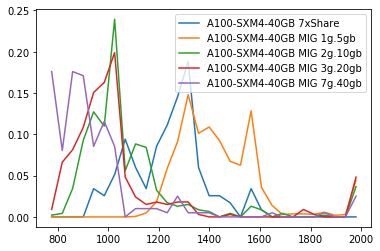

In [10]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("A100"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print(k, means[k],medians[k])
plt.legend()
plt.show()


 1011   972 Tesla V100-SXM2-16GB
 1435  1476 Tesla V100-SXM2-16GB 3xShare


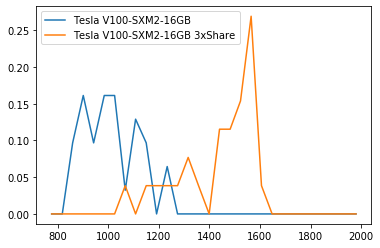

In [11]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla V"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %s"%(means[k],medians[k],k))
plt.legend()
plt.show()

  912   900 Tesla T4
 1606  1728 Tesla T4 3xShare


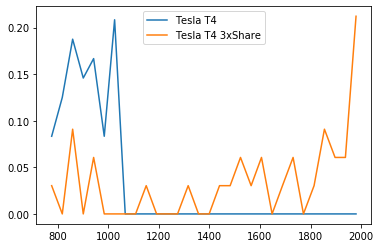

In [12]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla T"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %s"%(means[k],medians[k],k))
plt.legend()
plt.show()

In [13]:
data=parse(lines,2,"2022-02-1")
means,medians=get_means(data)
rtimes,rvals=hvals(data,bins=40)
save(data,means,medians,"runtimes.gwms_c2.csv")

 1448  1404 A100-SXM4-40GB MIG 1g.5gb
 1091  1044 A100-SXM4-40GB MIG 2g.10gb
 1040   972 A100-SXM4-40GB MIG 3g.20gb
  966   900 A100-SXM4-40GB MIG 7g.40gb


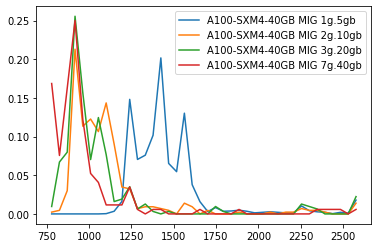

In [14]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %s"%(means[k],medians[k],k))
plt.legend()
plt.show()

In [15]:
data=parse(lines,1,"2022-02-2")
rtimes,rvals=hvals(data,bins=20)
means,medians=get_means(data)
save(data,means,medians,"runtimes.k8s_c1.csv")

 1730  1728 A100-SXM4-40GB 7xShare
 1769  1764 A100-SXM4-40GB MIG 1g.5gb
 1624  1620 A100-SXM4-40GB MIG 2g.10gb
 1488  1476 A100-SXM4-40GB MIG 3g.20gb
 1342  1332 A100-SXM4-40GB MIG 7g.40gb


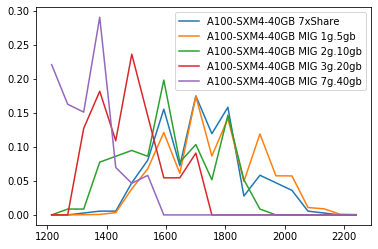

In [16]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("A100"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %s"%(means[k],medians[k],k))
plt.legend()
plt.show()


 1501  1476 Tesla V100-SXM2-16GB
 1718  1728 Tesla V100-SXM2-16GB 3xShare


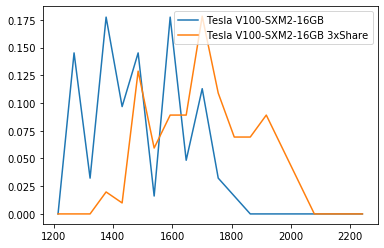

In [17]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla V"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %s"%(means[k],medians[k],k))
plt.legend()
plt.show()

 1500  1494 Tesla T4
 1762  1800 Tesla T4 3xShare


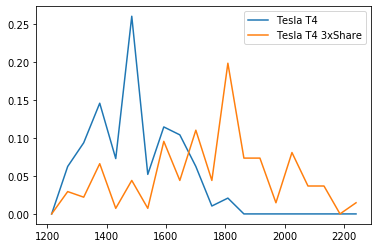

In [18]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla T"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %s"%(means[k],medians[k],k))
plt.legend()
plt.show()

In [19]:
data=parse(lines,2,"2022-02-2")
means,medians=get_means(data)
rtimes,rvals=hvals(data,bins=20)
save(data,means,medians,"runtimes.k8s_c2.csv")

  117  1231  1260 A100-SXM4-40GB 7xShare
  554  1398  1404 A100-SXM4-40GB MIG 1g.5gb
   32   987  1008 A100-SXM4-40GB MIG 2g.10gb
   19   951   972 A100-SXM4-40GB MIG 3g.20gb
   27   869   864 A100-SXM4-40GB MIG 7g.40gb


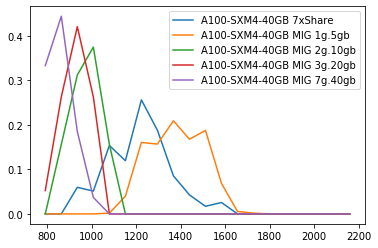

In [24]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("A100"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()

   31  1011   972 Tesla V100-SXM2-16GB
   26  1435  1476 Tesla V100-SXM2-16GB 3xShare


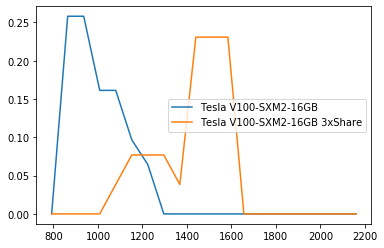

In [25]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla V"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()

   48   912   900 Tesla T4
   33  1606  1728 Tesla T4 3xShare


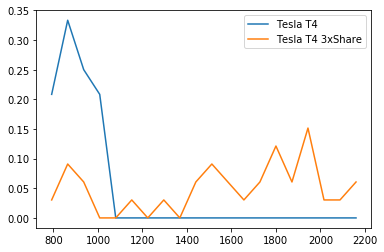

In [26]:
rkeys=list(rvals.keys())
rkeys.sort()
for k in rkeys:
    if not k.startswith("Tesla T"):
        continue
    plt.plot(rtimes, rvals[k], label=k)
    print("%5i %5i %5i %s"%(len(data[k]),means[k],medians[k],k))
plt.legend()
plt.show()